This notebook refers for [#6772 on diffusers](https://github.com/huggingface/diffusers/pull/6772) on ControlNet-XS.

It shows why

```py
def __init__(self, unet, controlnet_addon):
        super().__init__()
        controlnet = ControlNetXSModel(unet, controlnet_addon)        
        self.register_modules(controlnet=controlnet)
```

can't be used to initialize the pipeline. The core reason is that the init signature and registered modules need to be equal.

In [1]:
import torch
from torch import nn
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.models.modeling_utils import ModelMixin

In [2]:
device = 'mps' # I'm on Mac :)

x_cpu = torch.rand(2)
x_device = torch.rand(2, device=device)

x_cpu, x_device

(tensor([0.5452, 0.5050]), tensor([0.0297, 0.6164], device='mps:0'))

Define minimal example classes

In [3]:
class UNet(ModelMixin):
    def __init__(self):
        super().__init__()
        self.lin1, self.lin2 = nn.Linear(2,2), nn.Linear(2,2)
    def forward(self,x): pass


class ControlNetXSAddon(ModelMixin):
    def __init__(self):
        super().__init__()
        self.lin1, self.lin2 = nn.Linear(2,2), nn.Linear(2,2)
    def forward(self,x): raise EnvironmentError("Can't be forwarded by itself. Needs to part of a ControlNetXSModel.")


class ControlNetXSModel(nn.Module):
    def __init__(self, unet, control_addon):
        super().__init__()
        # store models separately for saving
        self.unet, self.control_addon = unet, control_addon
        # decompose models into their components and store them, to execute them interwovenly 
        self.lin1 = unet.lin1
        self.lin2 = control_addon.lin1
        self.lin3 = unet.lin2
        self.lin4 = control_addon.lin2

    @property
    def device(self) -> torch.device: return self.base.device

    @property
    def dtype(self) -> torch.dtype: return self.base.dtype
    
    def forward(self,x):
        for lin in [self.lin1, self.lin2, self.lin3, self.lin4]: x = lin(x)
        return x

In [4]:
class SimplePipe(DiffusionPipeline):
    model_cpu_offload_seq='controlnet'

    def __init__(self, unet, controlnet_addon):
        super().__init__()
        controlnet = ControlNetXSModel(unet, controlnet_addon)        
        self.register_modules(controlnet=controlnet)

    @torch.no_grad()
    def __call__(self, x): return self.controlnet(x)

**Create models and pipe**

In [5]:
unet = UNet()
control_addon = ControlNetXSAddon()

pipe = SimplePipe(unet, control_addon)

**Run cpu version**

This works

In [6]:
pipe(x_cpu)

tensor([ 0.1972, -0.4231])

**Run cpu-offloaded version**

This throws an error, because `pipe.components` is called and that function asserts that init signature and registered modules are the same.

In [7]:
pipe.enable_model_cpu_offload(device=device)

ValueError: SimplePipe {
  "_class_name": "SimplePipe",
  "_diffusers_version": "0.27.0.dev0",
  "controlnet": [
    "__main__",
    "ControlNetXSModel"
  ]
}
 has been incorrectly initialized or <class '__main__.SimplePipe'> is incorrectly implemented. Expected {'unet', 'controlnet_addon'} to be defined, but dict_keys(['controlnet']) are defined.

In `enable_model_cpu_offload`, the error occurs in this line

In [8]:
pipe.components

ValueError: SimplePipe {
  "_class_name": "SimplePipe",
  "_diffusers_version": "0.27.0.dev0",
  "controlnet": [
    "__main__",
    "ControlNetXSModel"
  ]
}
 has been incorrectly initialized or <class '__main__.SimplePipe'> is incorrectly implemented. Expected {'unet', 'controlnet_addon'} to be defined, but dict_keys(['controlnet']) are defined.

`pipe.components` expects the registered objects and init signature to be equal

Here's the code from `pipeline_utils.py`

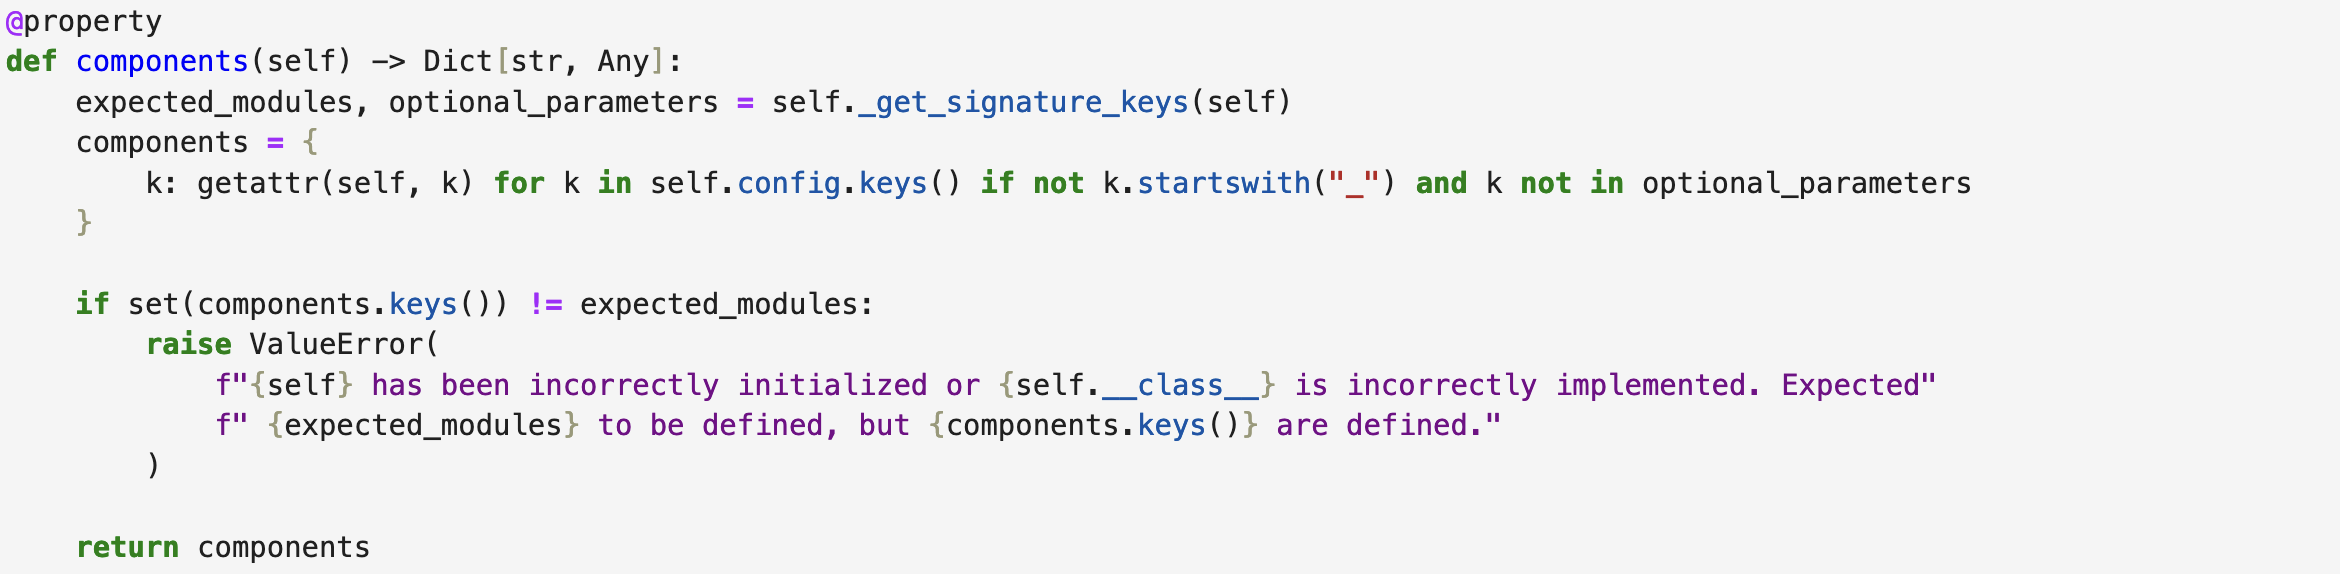